In [1]:
from main import *
from visualization import *

%matplotlib inline
plt.rcParams['font.size'] = 6

centroids_motor = np.load('Results/figure5_centroids_motor.npy')
p_motor = np.load('Results/figure5_pvalues_motor.npy')
significance = 0.025

# Setting paths

In [2]:
top_directory = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/'
atlas_path = '/home/anleg84/Documents/Atlas/MapzebrainOld/'

In [3]:
atlas = MapzebrainAtlas(atlas_path)
centroids = np.concatenate([atlas.regionCentroids['left'], atlas.regionCentroids['right']], axis=0)
centroids[:, 1] = 974 - centroids[:, 1]
excluded = np.load('Results/excluded_regions.npy')

centroids_ = np.delete(centroids, np.concatenate([excluded, excluded + 70]), axis=0)

In [4]:
datasets = get_datasets(top_directory, keywords=['920nm'])

# Loading figure-related data

In [5]:
import cv2
def load_frame(video_path, frame_number):
    cap = cv2.VideoCapture(video_path)
    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
    success, frame = cap.read()
    if success:
        return frame
    else:
        print("Error: Could not read frame")
        return None

In [6]:
folder = datasets[8]
camera_path = '/media/anleg84/Backup Plus/CERVO/Data/Networks2024/20230801-Wholebrain-6dpf/20230801-Camera/fish4/'

path = camera_path + identify_files(camera_path, ['.avi'])[0]
frame = load_frame(path, 146575)
background = np.load(camera_path + identify_files(camera_path, ['.npy'])[0])
x_tail = np.load(camera_path + identify_files(camera_path, ['.npy'])[1])[:, 146575]
y_tail = np.load(camera_path + identify_files(camera_path, ['.npy'])[2])[:, 146575]

file = identify_files(folder, ['tail', 'angles', '.npy'])[0]
angles = np.load(folder + file)
tail = TailAnalysis(angles, 399.75)
curvature = tail.curvature
events = np.load(folder + 'swim_events.npy')
vector = (events > 0.5).astype('int')[15:]
vector = np.concatenate([vector, [0] * 15])
if len(vector) != 360000:
    vector = np.concatenate([vector, [0] * (360000 - len(vector))])
events = vector

timeseries = np.load(folder + 'dff.npy')
motor_corrs = np.load(folder + 'correlations_motor.npy')
dark_corrs = np.load(folder + 'correlations_dark.npy')
light_corrs = np.load(folder + 'correlations_light.npy')

atlas_stack = load_stack('Data/atlas_H2BGCaMP6s.tif')
density_motor = load_stack('Results/figure5_density_motor_thresholded.tif')
density_antimotor = load_stack('Results/figure5_density_antimotor_thresholded.tif')
density_light = load_stack('Results/figure5_density_light_thresholded.tif')
density_dark = load_stack('Results/figure5_density_dark_thresholded.tif')

stacks = [atlas_stack, density_motor, density_antimotor, density_dark, density_light]
projections_top, projections_side = [], []
for s in stacks:
    projections_top.append(np.mean(s, axis=0))
    projections_side.append(np.mean(s, axis=2))

colors_projections = [[0.7, 0.7, 0.7],
         [0, 0.8, 0.2],
         [1, 0, 1],
         [1, 0, 0],
         [0.95, 0.95, 0]]

top_merged = merge(projections_top, colors_projections, gain=10, cutoff=0.3, contrast=True)
side_merged = merge(projections_side, colors_projections, gain=12, cutoff=0.25, contrast=True)

sequence = np.load('Data/sequence_15mins_light_darkflash.npy')
sequence = np.concatenate([sequence[3:], sequence[:3]])
sequence_image = np.zeros((1, 900, 3))
for i, stim in enumerate(sequence):
    if stim == 'dark':
        sequence_image[0, i, :] = [0, 0, 0]
    else:
        sequence_image[0, i, :] = [1, 1, 1]

centroids_dark = np.load('Results/figure5_centroids_dark.npy')
centroids_light = np.load('Results/figure5_centroids_light.npy')
centroids_motor = np.load('Results/figure5_centroids_motor.npy')
centroids_antimotor = np.load('Results/figure5_centroids_antimotor.npy')

p_motor = np.load('Results/figure5_pvalues_motor.npy')
p_antimotor = np.load('Results/figure5_pvalues_antimotor.npy')
p_dark = np.load('Results/figure5_pvalues_dark.npy')
p_light = np.load('Results/figure5_pvalues_light.npy')

significance = 0.025
rho_dark = compute_density_atlas(centroids_dark[p_dark < significance], sigma=10)
rho_light = compute_density_atlas(centroids_light[p_light < significance], sigma=10)
rho_motor = compute_density_atlas(centroids_motor[p_motor < significance], sigma=10)
rho_antimotor = compute_density_atlas(centroids_antimotor[p_antimotor < significance], sigma=10)

overlap_matrices = np.load('Results/figure5_overlap_matrices.npy')
adjusted_diversity = np.load('Results/figure5_adjusted_regional_diversity.npy')

centroids_polyfunctional = np.load('Results/figure5_centroids_polyfunctional.npy')
rho_polyfunctional = compute_density_atlas(centroids_polyfunctional, sigma=10)

N_per_categories = np.diag(np.mean(overlap_matrices[:-1], axis=0))
std_per_categories = np.diag(np.std(overlap_matrices[:-1], axis=0))

N_per_overlap = np.mean(overlap_matrices[:-1], axis=0)[:2, 2:].flatten()
std_per_overlap = np.std(overlap_matrices[:-1], axis=0)[:2, 2:].flatten()

# Figure 5 layout

In [7]:
cmap = 'rainbow'
cmap2 = 'rainbow'

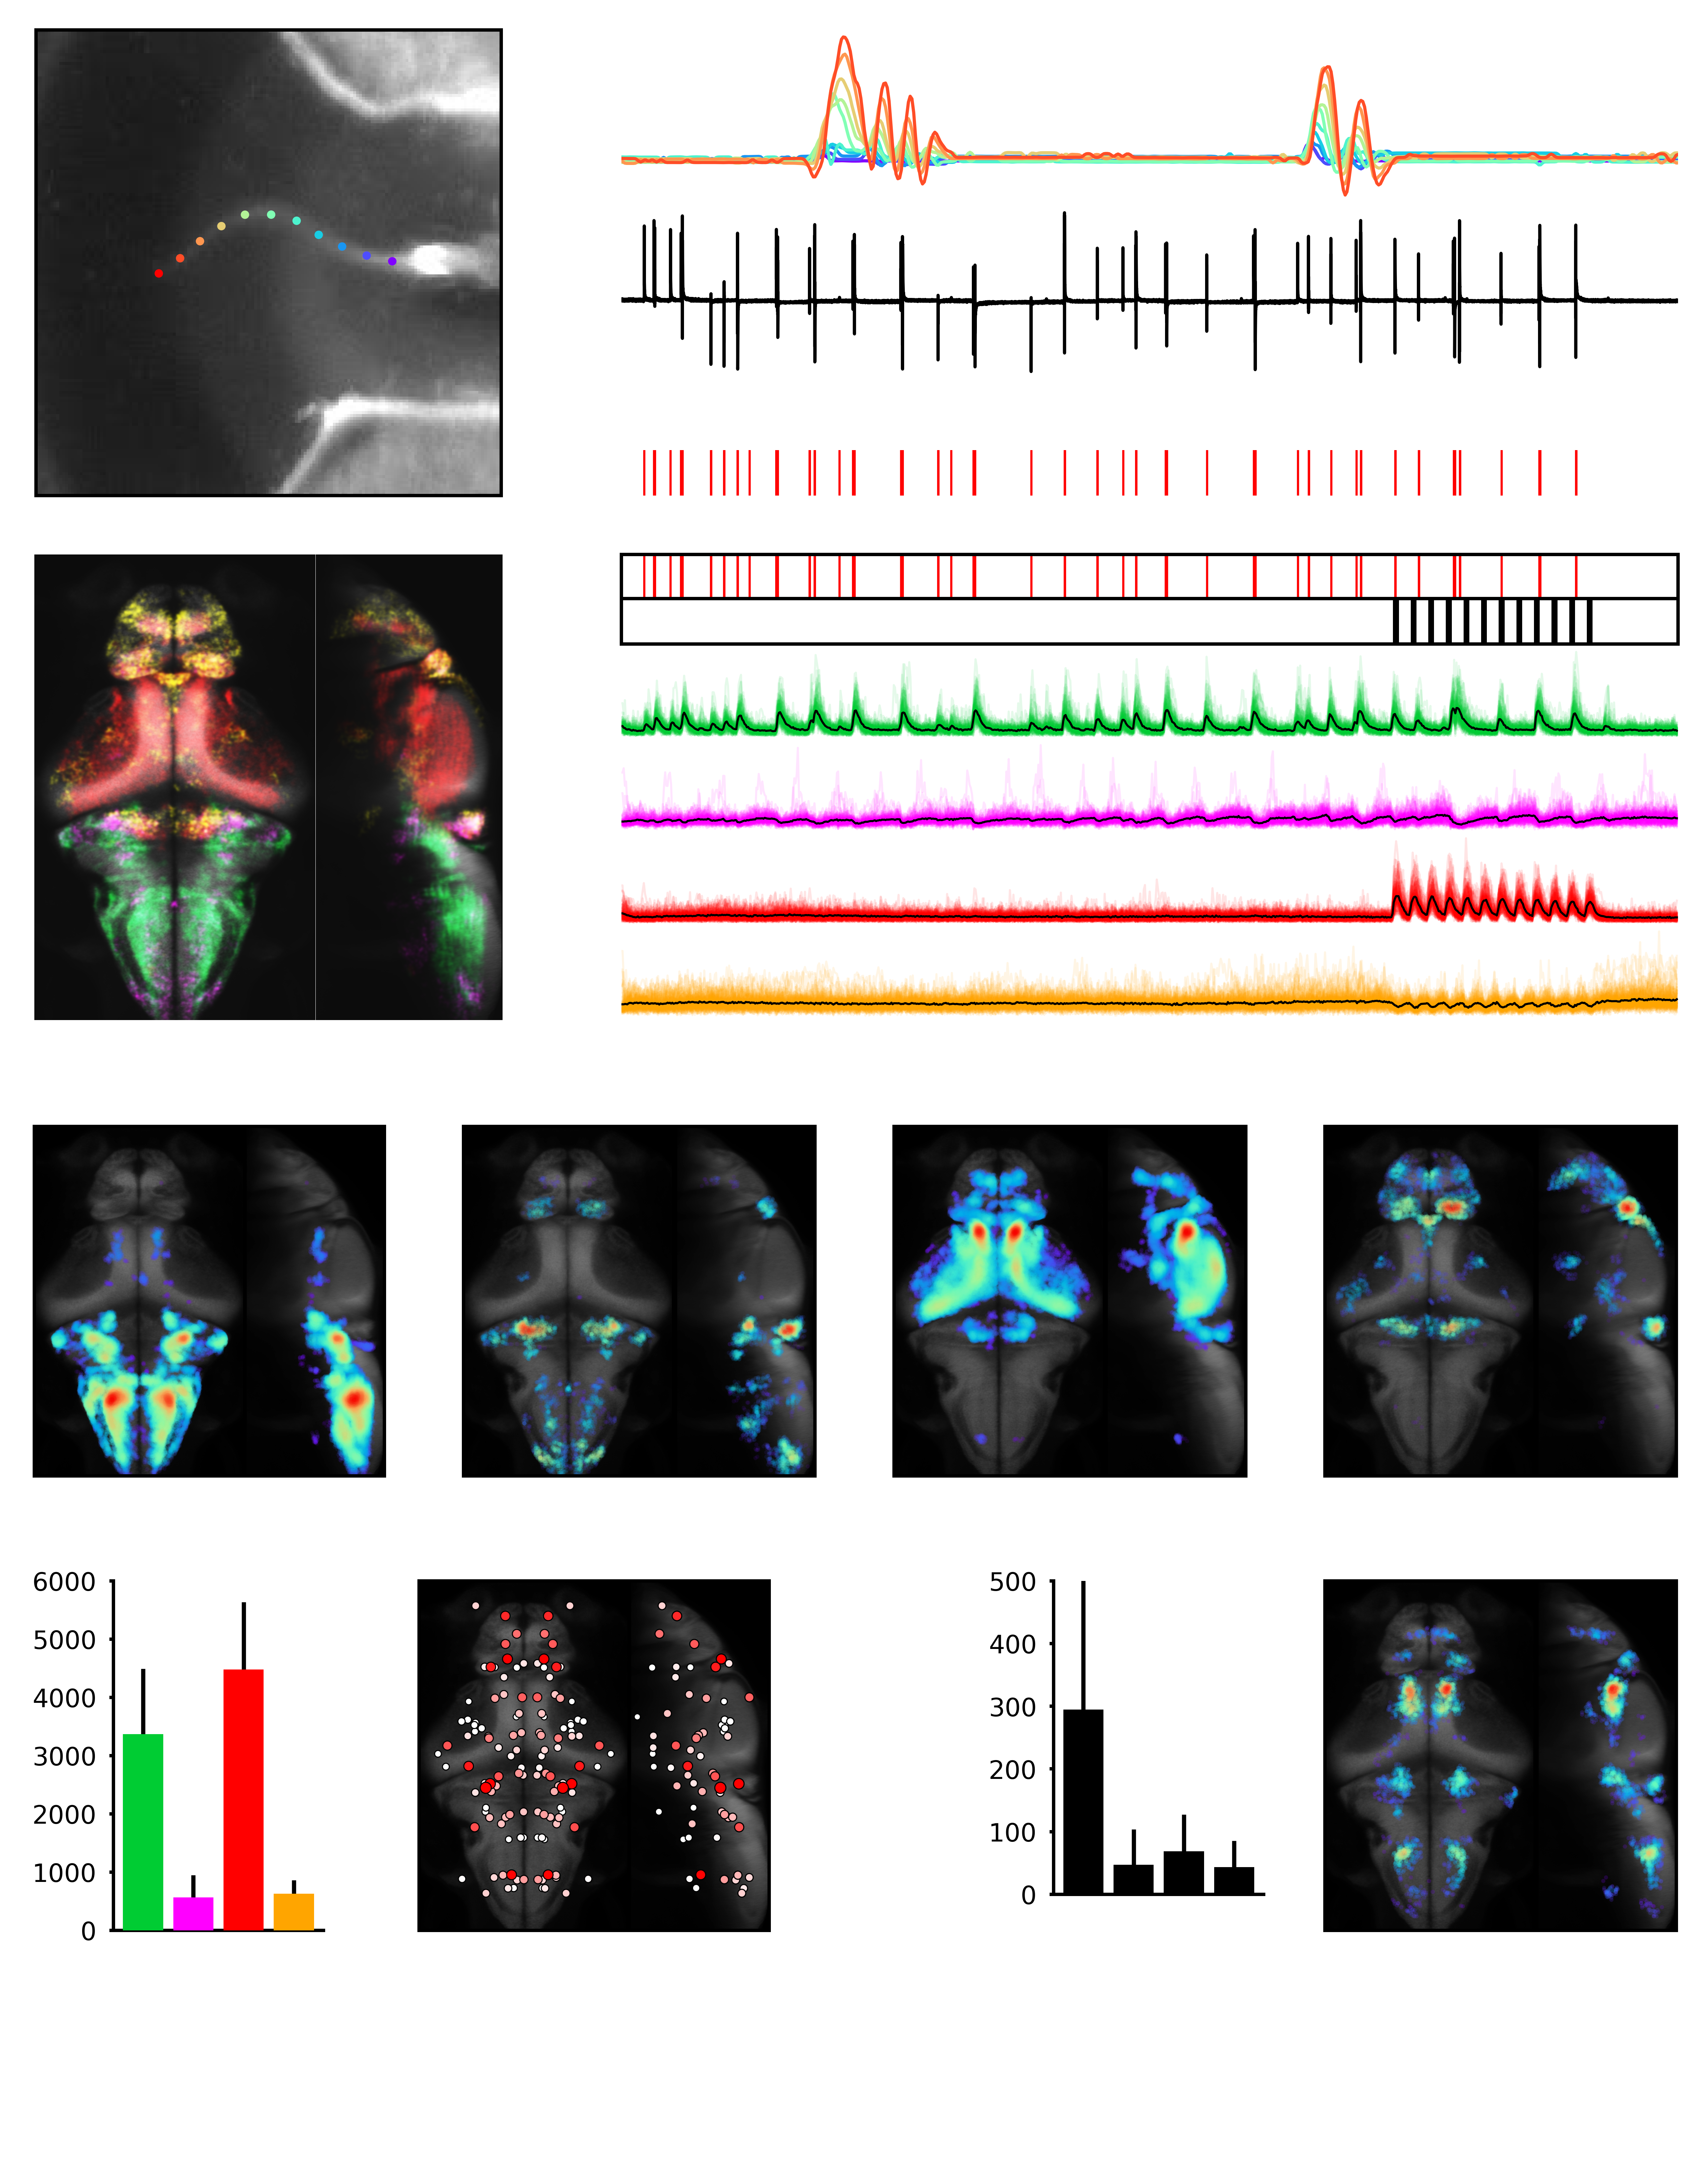

In [8]:
fig = PaperFigure(figsize=(7, 9), dpi=900)

fig.set_tick_length(1)
fig.set_font_size(6)
fig.add_background()

# Layout ----------------------------------------------------------------------

fig.add_axes('camera', (0, 0), 2, 2)

fig.add_axes('motor_trace_zoom', (2.5, 0), 5, 0.75)
fig.add_axes('motor_trace', (2.5, 0.75), 5, 0.75)
fig.add_axes('trace_events1', (2.5, 1.8), 5, 0.2)

h = 0.4
y = 2.25

fig.add_axes('trace_events', (2.5, y), 5, h/2)
fig.add_axes('trace_stim', (2.5, y + (h/2) - 0.01), 5, h/2)

fig.add_axes('trace_motor+', (2.5, y + h), 5, h)
fig.add_axes('trace_motor-', (2.5, y + 2*h), 5, h)
fig.add_axes('trace_dark', (2.5, y + 3 * h), 5, h)
fig.add_axes('trace_light', (2.5, y + 4 * h), 5, h)

fig.add_axes('projection_top', (0, 2.25), 0.6 * 2, 2)
fig.add_axes('projection_side', (0.6 * 2, 2.25), 0.4 * 2, 2)

y = 4.7
w = 1.5
pad = (7 - (4 * w)) / 3
fig.add_axes('centroids1_top', (0, y), w * 0.6, w)
fig.add_axes('centroids1_side', (0.6 * w, y), w * 0.4, w)
fig.add_axes('centroids2_top', (1 * (w + pad), y), w * 0.6, w)
fig.add_axes('centroids2_side', (1 * (w + pad) + (0.6 * w), y), w * 0.4, w)
fig.add_axes('centroids3_top', (2 * (w + pad), y), w * 0.6, w)
fig.add_axes('centroids3_side', (2 * (w + pad) + (0.6 * w), y), w * 0.4, w)
fig.add_axes('centroids4_top', (3 * (w + pad), y), w * 0.6, w)
fig.add_axes('centroids4_side', (3 * (w + pad) + (0.6 * w), y), w * 0.4, w)


y = 6.65
#fig.add_axes('overlap_matrix', (0, y), w, w)
fig.add_axes('barchart_numbers', (0.34, y), 0.9, w)

x = 0.34 + 1 + 0.3
fig.add_axes('diversity_top', (x, y), w * 0.6, w)
fig.add_axes('diversity_side', (x + 0.6 * w, y), w * 0.4, w)

fig.add_axes('barchart_overlaps', (x + w + 1.2, y), 0.9, w * 0.9)

fig.add_axes('polyfunctional_top', (3 * (w + pad), y), w * 0.6, w)
fig.add_axes('polyfunctional_side', (3 * (w + pad) + (0.6 * w), y), w * 0.4, w)


# Content ---------------------------------------------------------------------

# First row

ax = fig.axes['camera']
ax.imshow(frame)
ax.scatter(x_tail, y_tail, s=1, c=np.arange(11), cmap=cmap)
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['motor_trace']
t = np.linspace(0, 900, 360000, endpoint=False)
ax.plot(t, curvature, color='black', linewidth=0.75)
#i = int((87.3 / 900) * 360000)
#ax.text(87.3, np.max(curvature[i-400:i+400]) + 3, '1', color='red', ha='center', va='center', fontsize=4)
#i = int((629.5 / 900) * 360000)
#ax.text(629.5, np.max(curvature[i-400:i+400]) + 3, '2', color='red', ha='center', va='center', fontsize=4)
ax.set_xlim([0, 900])
ax.axis('off')

ax = fig.axes['motor_trace_zoom']
x = 87.3
color_ids = np.linspace(0, 0.9, 10)
for i in range(10):
    color = PaperFigure.get_cmap_color(cmap, color_ids[i])
    ax.plot(tail.angles[i], color=color, linewidth=0.75, zorder=i)
#ax.plot([x, x + 0.1], [scale_y, scale_y], color='black', linewidth=1)
#ax.text(x + 0.05, scale_y + 0.2, '100 ms', ha='center', va='bottom', font='Arial')
ax.set_xlim([11000, 11600])
ax.set_ylim([-1, 3])
ax.axis('off')

ax = fig.axes['trace_events1']
ax.eventplot(np.where(np.abs(np.diff(events)))[0] * (1/399.75), color='red', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, 900])
ax.set_ylim([0.5, 1.5])
ax.axis('off')

ax = fig.axes['trace_events']
ax.eventplot(np.where(np.abs(np.diff(events)))[0] * (1/399.75), color='red', linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, 900])
ax.set_ylim([0.5, 1.5])
#ax.axis('off')

ax = fig.axes['trace_stim']
#ax.eventplot(np.where(sequence == 'dark')[0], color='black', linewidth=0.5, zorder=10)
#ax.eventplot(np.where(sequence == 'light')[0], color='red', linewidth=0.5)
ax.imshow(sequence_image, aspect='auto', interpolation='None')
ax.set_xticks([])
ax.set_yticks([])
#ax.axis('off')

# Second row

ax = fig.axes['trace_motor+']
ts = timeseries[np.argsort(motor_corrs)[-100:]]
for signal in ts:
    ax.plot(np.arange(len(signal)), signal, color=[0, 0.8, 0.2], alpha=0.1, linewidth=0.5, rasterized=True)
ax.plot(np.arange(len(signal)), np.mean(ts, axis=0), color=[0, 0, 0], alpha=1, linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, ts.shape[1]])
ax.axis('off')

ax = fig.axes['trace_motor-']
ts = timeseries[np.argsort(motor_corrs)[:100]]
for signal in ts:
    ax.plot(np.arange(len(signal)), signal, color=[1, 0, 1], alpha=0.1, linewidth=0.5, rasterized=True)
ax.plot(np.arange(len(signal)), np.mean(ts, axis=0), color=[0, 0, 0], alpha=1, linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, ts.shape[1]])
ax.axis('off')

ax = fig.axes['trace_dark']
ts = timeseries[np.argsort(dark_corrs)[-100:]]
for signal in ts:
    ax.plot(np.arange(len(signal)), signal, color=[1, 0, 0], alpha=0.1, linewidth=0.5, rasterized=True)
ax.plot(np.arange(len(signal)), np.mean(ts, axis=0), color=[0, 0, 0], alpha=1, linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, ts.shape[1]])
ax.axis('off')

ax = fig.axes['trace_light']
ts = timeseries[np.argsort(light_corrs)[-100:]]
for signal in ts:
    ax.plot(np.arange(len(signal)), signal, color='orange', alpha=0.1, linewidth=0.5, rasterized=True)
ax.plot(np.arange(len(signal)), np.mean(ts, axis=0), color=[0, 0, 0], alpha=1, linewidth=0.5)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim([0, ts.shape[1]])
ax.axis('off')

ax = fig.axes['projection_top']
ax.imshow(top_merged, aspect='auto')
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.axis('off')

ax = fig.axes['projection_side']
ax.imshow(np.rot90(side_merged, k=3), aspect='auto')
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.axis('off')

ax = fig.axes['centroids1_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', vmax=200)
order = np.argsort(rho_motor)
c = centroids_motor[p_motor < significance]
ax.scatter(c[order, 0], c[order, 1], c=rho_motor[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids1_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=rho_motor[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids2_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', vmax=200)
order = np.argsort(rho_antimotor)
c = centroids_antimotor[p_antimotor < significance]
ax.scatter(c[order, 0], c[order, 1], c=rho_antimotor[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids2_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=rho_antimotor[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids3_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', vmax=200)
order = np.argsort(rho_dark)
c = centroids_dark[p_dark < significance]
ax.scatter(c[order, 0], c[order, 1], c=rho_dark[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids3_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=rho_dark[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids4_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', vmax=200)
order = np.argsort(rho_light)
c = centroids_light[p_light < significance]
ax.scatter(c[order, 0], c[order, 1], c=rho_light[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['centroids4_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=rho_light[order], cmap=cmap2, alpha=0.1, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['barchart_numbers']
colors = [[0, 0.8, 0.2], [1, 0, 1], [1, 0, 0], 'orange']
ax.bar([0, 1, 2, 3], N_per_categories, color=colors, zorder=10)
for i in range(4):
    ax.plot([i, i], [N_per_categories[i], N_per_categories[i] + std_per_categories[i]], color='black', zorder=-10, linewidth=1)
#ax.set_yscale('log')
ax.set_xticks([])
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0, 6000])

cmap_red = make_cmap([[1, 1, 1], [1, 0, 0]], [0, 1])
ax = fig.axes['diversity_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', vmax=200)
c = centroids_
d = double(np.delete(adjusted_diversity, excluded))
order = np.argsort(d)
ax.scatter(c[order, 0], c[order, 1], c=d[order], cmap=cmap_red, alpha=1, edgecolor='black', linewidth=0.25, s=2 + (d[order] / 2), rasterized=True, vmin=2, vmax=7)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['diversity_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=d[order], cmap=cmap_red, alpha=1, edgecolor='black', linewidth=0.25, s=2 + (d[order] / 2), rasterized=True, vmin=2, vmax=7)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['barchart_overlaps']
colors = [[0, 0.8, 0.2], [1, 0, 1], [1, 0, 0], 'orange']
ax.bar([0, 1, 2, 3], N_per_overlap, color='black')
for i in range(4):
    ax.plot([i, i], [N_per_overlap[i], N_per_overlap[i] + std_per_overlap[i]], color='black', zorder=-10, linewidth=1)
#ax.set_yscale('log')
ax.set_xticks([])
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylim([0, 500])

ax = fig.axes['polyfunctional_top']
ax.imshow(atlas.XYprojection, aspect='auto', cmap='gray', alpha=1, vmax=200)
order = np.argsort(rho_polyfunctional)
c = centroids_polyfunctional
ax.scatter(c[order, 0], c[order, 1], c=rho_polyfunctional[order], cmap=cmap2, alpha=0.2, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([65, 505])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

ax = fig.axes['polyfunctional_side']
ax.imshow(np.rot90(atlas.XZprojection, k=3), aspect='auto', cmap='gray', alpha=1, vmax=200)
ax.scatter(359 - c[order, 2], c[order, 1], c=rho_polyfunctional[order], cmap=cmap2, alpha=0.2, edgecolor='None', s=1, rasterized=True)
ax.set_xlim([50, 359])
ax.set_ylim([850, 50])
ax.set_xticks([])
ax.set_yticks([])

# Display ---------------------------------------------------------------------

fig.show()

In [16]:
fig.save('/home/anleg84/Documents/Figures/PaperNetworks2024/figure5_incomplete.svg')

# Manually written numbers

#### Number of cells per spatial density

In [20]:
centroids_motor[p_motor < significance].shape[0]

37207

In [21]:
centroids_antimotor[p_antimotor < significance].shape[0]

4204

In [22]:
centroids_dark[p_dark < significance].shape[0]

57423

In [23]:
centroids_light[p_light < significance].shape[0]

4700

In [64]:
centroids_polyfunctional.shape[0]

2874

#### Arbitrary density values (for scale bars)

In [28]:
np.max(rho_motor) / np.max(rho_dark)

0.7093681780540405

In [30]:
np.max(rho_antimotor) / np.max(rho_dark)

0.16343688801974213

In [34]:
np.max(rho_dark) / np.max(rho_dark)

1.0

In [35]:
np.max(rho_light) / np.max(rho_dark)

0.19788259459163055

In [57]:
np.max(rho_polyfunctional) / np.max(rho_dark)

0.1331976065788019

In [59]:
np.min(rho_polyfunctional)

6.925308800238306e-05

#### Number of cells per functional category per animal (for main text)

In [19]:
N_per_categories

array([3369.44444444,  567.16666667, 4479.94444444,  627.88888889])

In [20]:
std_per_categories

array([1085.068212  ,  347.23835074, 1119.76438356,  195.40922556])